# Reinforcement Learning Project: Chutes and Ladders

### Andrew Angulo, Liam Quinlan, Daniel Ziabicki

In [35]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import pprint


---
## Dynamic Programming

define board

In [36]:
#space you land on : space it moves you to
ladders = {1:38, 4:14, 9:31, 21:42, 28:84, 36:44, 51:67, 71:91, 80:100}
chutes = {16:6, 47:26, 49:11, 56:53, 64:60, 87:24, 93:73, 95:75, 98:78}

game_map = {}

for i in range(101):
    if i not in ladders.keys() and i not in chutes.keys():
        game_map[i] = i

game_map.update(ladders)
game_map.update(chutes)

init_state = 0
final_state = 100
reward = -1

define actions

In [37]:
dice = {
    'RED': [2, 2, 2, 2, 6, 6],
    'BLUE': [3, 3, 3, 3, 3, 3],
    'GREEN': [1, 1, 1, 5, 5, 5],
    'BLACK': [0, 0, 4, 4, 4, 4]
}

initialize policy and value functions, initialize hyper parameters

In [38]:
def initFunctions():
    policy = {state:'RED' for state in game_map.keys()}

    value = {}
    for state in game_map.keys():
        for action in dice.keys():
            value[(state, action)] = -1

    return policy, value

alpha = 0.2
epsilon = 0.1
gamma = 0.99

helper functions

select action based on value function

compute best policy from value function

roll the selected dice

In [39]:
def selectAction(value, state): #epsilon-greedy
    """
    Takes in the value function and the current state. Searches the value function's data
    for the action with the highest value. Returns that action
    """
    best_action = 'RED'
    for i, action in value.keys():
        if i == state and value[(i, action)] > value[(i, best_action)]:
            best_action = action
    if random.random() < epsilon:
        return random.choice(list(dice.keys()))
    else:
        return best_action

def computePolicy(value):
    policy = {}
    for state in game_map.keys():
        if state in chutes.keys() or state in ladders.keys():
            continue
        opt_action = "RED"
        for action in dice.keys():
            if value[(state, action)] > value[(state, opt_action)]:
                opt_action = action
        policy[state] = opt_action
    return policy

def rollDice(dice_color):
    return random.choice(dice[dice_color])

more helper functions geared toward visualizing the results from the learning

1. plot state against value to see how the value changes. Each dice roll has it's own color line, showing which state action pair has the best value for a given state
2. construct a plot of the game based on the policy. The color of the square represents the optimal dice roll

In [40]:
def plot_value(data_dict):

    color_data = defaultdict(lambda: defaultdict(list))
    for (integer, color), number in data_dict.items():
        if number != -1 and number != 0:  # skip default values
            color_data[color]['x'].append(integer)
            color_data[color]['y'].append(number)
        # else:
        #     print(integer)

    plt.figure(figsize=(10, 6))

    for color, values in color_data.items():
        x_values = values['x']
        y_values = values['y']

        plt.plot(x_values, y_values, label=color, color=color)

    plt.xlabel('State')
    plt.ylabel('Value')
    plt.title('Value as a function of State given an Action')
    plt.legend(title="Actions")

    plt.show()

def plot_policy(policy):
    """Takes in a policy dictionary (map from state:action) and draws in on the board"""
    grid = np.zeros((10, 10), dtype=int)

    #creates and numbers the base 1-100 grid
    number = 1
    for row in range(10):
        #logic to snake the numbers
        if row % 2 == 0:
            for col in range(10):
                grid[9 - row, col] = number
                number += 1
        else:
            for col in range(9, -1, -1):
                grid[9 - row, col] = number
                number += 1

    #create 2d matrix of colors
    colors = []
    for row in range(10):
        row_colors = []
        for col in range(10):
            cell_number = grid[row, col]
            row_colors.append(policy.get(cell_number, 'grey'))  # Default to grey if not in policy
        colors.append(row_colors)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    # account for starting square 0. Placed it to the left of the 1st spot outside of the 10x10 grid
    ax.add_patch(
        plt.Rectangle((-1, 9), 1, 1, color=policy.get(0, 'grey'))
    )
    ax.text(
        -0.5, 9.5, '0',
        color='white', ha='center', va='center', fontsize=8
    )

    # actually draw the grid
    for row in range(10):
        for col in range(10):
            ax.add_patch(
                plt.Rectangle((col, row), 1, 1, color=colors[row][col])
            )
            ax.text(
                col + 0.5, row + 0.5, str(grid[row, col]),
                color='white', ha='center', va='center', fontsize=8
            )

    ax.set_xlim(-1, 10)
    ax.set_ylim(0, 10)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.gca().invert_yaxis()
    plt.show()

In [41]:
def SARSA(num_trials):
    policy, value = initFunctions() #initialize Q, Pi
    for i in range(num_trials): #for each trial/experience
        state = init_state #start from the initial state 0
        action = selectAction(value, state) #choose an action from the current value function
        while state != final_state:

            #apply the action - roll the dice and move to new state. If that new state is out of bounds or 100, you win!
            dice_roll = rollDice(action)
            if state+dice_roll > 100:
                new_state = 100
            else:
                new_state = game_map[state+dice_roll]

            #apply td error learning function to update value of state action pair
            new_action = selectAction(value, new_state)
            value[(state, action)] += alpha*(reward + gamma*value[(new_state, new_action)] - value[(state, action)])

            #reset for next loop
            state = new_state
            action = new_action
    policy = computePolicy(value)
    return policy, value

In [42]:
def QLearning(num_trials):
    policy, value = initFunctions() #init Q, Pi
    for i in range(num_trials):
        state = init_state
        while state != final_state:
            action = selectAction(value, state)
            dice_roll = rollDice(action)
            if state+dice_roll > 100:
                new_state = 100
            else:
                new_state = game_map[state+dice_roll]

            max_future_q = max(value[(new_state, a)] for a in dice.keys()) #value given optimal choice in action
            value[(state, action)] += alpha * (reward + gamma * max_future_q - value[(state, action)])

            state = new_state

    policy = computePolicy(value)
    return policy, value

{(0, 'RED'): -8.086322270150154, (0, 'BLUE'): -8.318815764867459, (0, 'GREEN'): -8.439833637471327, (0, 'BLACK'): -8.54541506904551, (2, 'RED'): -7.875136913155033, (2, 'BLUE'): -8.47803076716579, (2, 'GREEN'): -8.104953197294337, (2, 'BLACK'): -8.193749743217564, (3, 'RED'): -8.494573536281216, (3, 'BLUE'): -8.321155404287133, (3, 'GREEN'): -8.372325400190201, (3, 'BLACK'): -8.289410117994885, (5, 'RED'): -8.116400927743147, (5, 'BLUE'): -8.199782860350227, (5, 'GREEN'): -8.0960678372412, (5, 'BLACK'): -7.751411619238844, (6, 'RED'): -8.00516489588562, (6, 'BLUE'): -7.811046090204802, (6, 'GREEN'): -7.995757656873557, (6, 'BLACK'): -7.98330233194025, (7, 'RED'): -7.502825937577791, (7, 'BLUE'): -8.179472260748538, (7, 'GREEN'): -8.06737643518837, (7, 'BLACK'): -8.30444137990201, (8, 'RED'): -8.343885342382432, (8, 'BLUE'): -7.511034944146604, (8, 'GREEN'): -8.380675949711772, (8, 'BLACK'): -8.4213250159875, (10, 'RED'): -7.681506278745125, (10, 'BLUE'): -8.113140547350817, (10, 'GREEN

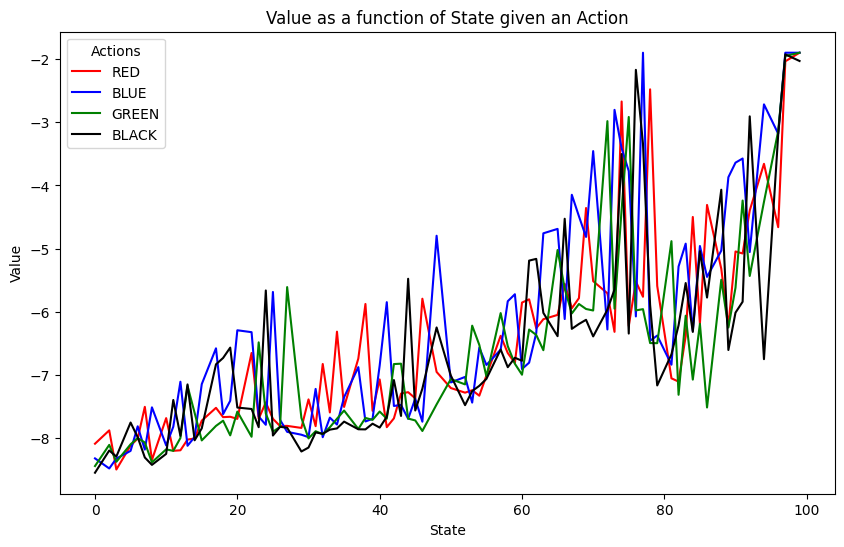

{(0, 'RED'): -7.192285927075976, (0, 'BLUE'): -7.529164129520678, (0, 'GREEN'): -7.518655259451041, (0, 'BLACK'): -7.63620103724732, (2, 'RED'): -7.379151419452212, (2, 'BLUE'): -7.610553330686385, (2, 'GREEN'): -7.526180138825103, (2, 'BLACK'): -7.223246611656984, (3, 'RED'): -7.526913398468053, (3, 'BLUE'): -7.591383524140048, (3, 'GREEN'): -7.1385117383365975, (3, 'BLACK'): -7.616367325035693, (5, 'RED'): -7.27856372084329, (5, 'BLUE'): -7.619888445168579, (5, 'GREEN'): -7.402705572283725, (5, 'BLACK'): -7.455908380090449, (6, 'RED'): -7.196100879687864, (6, 'BLUE'): -6.299720026783759, (6, 'GREEN'): -7.25665288600898, (6, 'BLACK'): -7.451912184487641, (7, 'RED'): -7.165379959200693, (7, 'BLUE'): -7.390607012766424, (7, 'GREEN'): -7.309138017450692, (7, 'BLACK'): -7.3765769257739, (8, 'RED'): -7.476357448829147, (8, 'BLUE'): -7.438038102360422, (8, 'GREEN'): -7.0028866023265515, (8, 'BLACK'): -7.1853287926563105, (10, 'RED'): -7.312418047587875, (10, 'BLUE'): -7.15167756350216, (10,

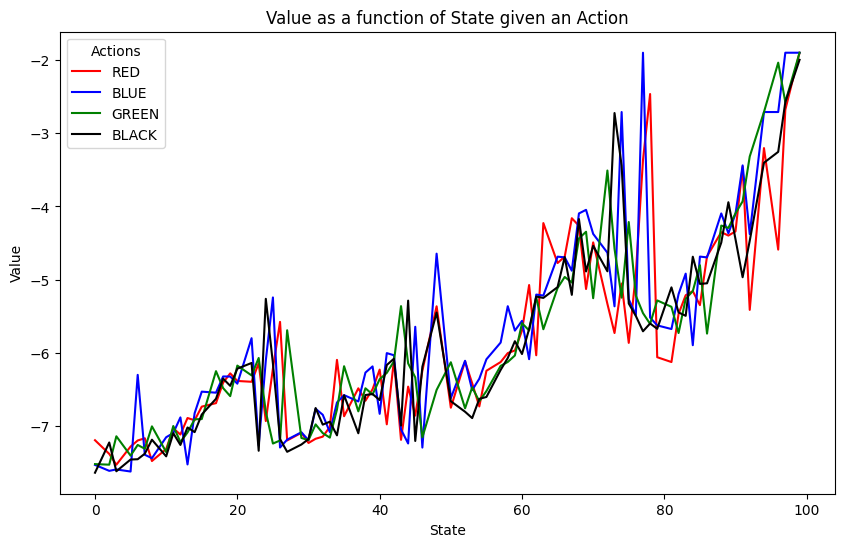

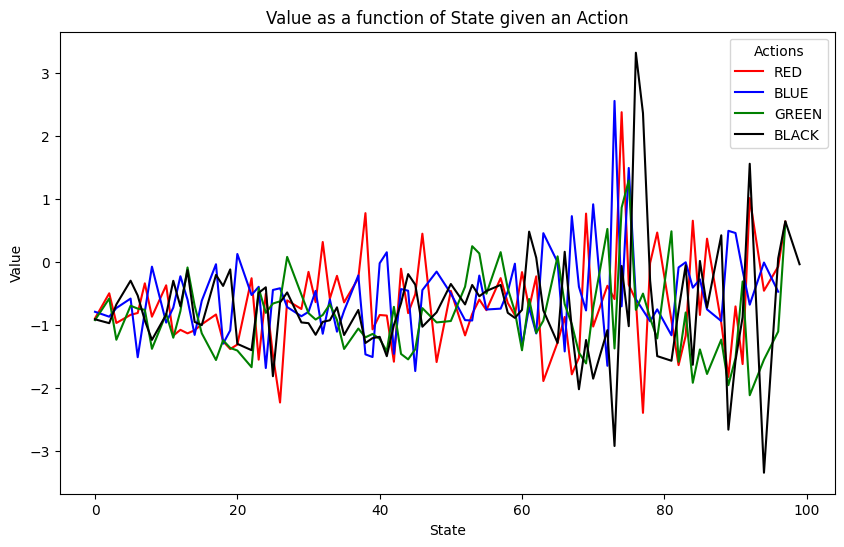

In [43]:
p_sarsa, v_sarsa = SARSA(10000)

print(v_sarsa)
print(p_sarsa)
plot_value(v_sarsa)

p_qlearning, v_qlearning = QLearning(10000)

print(v_qlearning)
print(p_qlearning)
plot_value(v_qlearning)

diff_dict = {}
for key, value in v_sarsa.items():
    diff_dict[key] = value - v_qlearning[key]

plot_value(diff_dict)

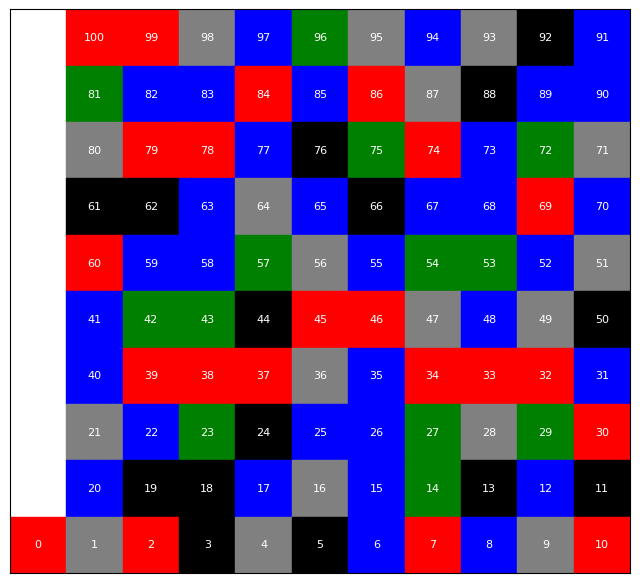

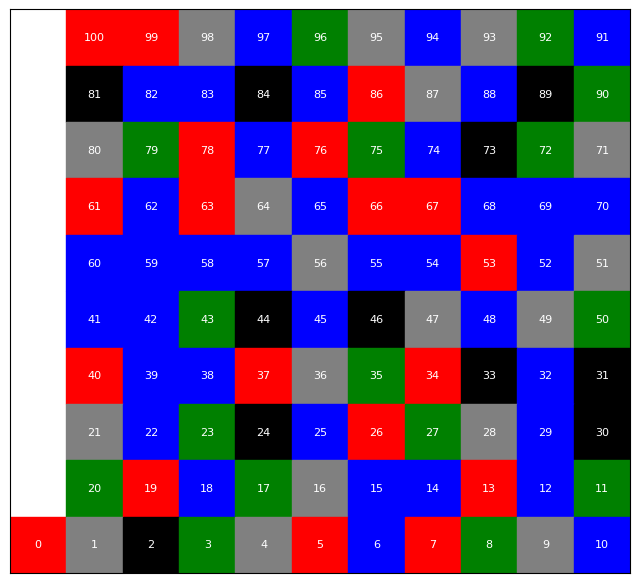

In [44]:
plot_policy(p_sarsa)
plot_policy(p_qlearning)

---
## Monte Carlo

Monte Carlo Functions

In [45]:
#======================================================
def trajectory(value):
  '''
  Simulate one trajectory of experience
  Return list of states during trajectory
  '''
  traj = []
  state = 0
  i = 0

  while ( state < 100 and i < 100 ):
    action = selectAction(value, state)
    dice_roll = rollDice(action)

    if state + dice_roll > 100:
      new_state = 100
    else:
      new_state = game_map[state + dice_roll]

    s_prev = state
    state = new_state
    traj.append((s_prev,action,reward))
    i += 1

  return traj

#======================================================
def monteCarlo(n):
  policy, value = initFunctions()

  for i in range(n):
    # run trajectory
    traj = trajectory(value)
    G = 0

    # iterate through trajectory and update Q values
    for t in reversed(range(len(traj))):
      state, action, reward = traj[t]

      G = reward + gamma * G
      
      value[(state, action)] += alpha * (G - value[(state, action)])

    # update policy function
    policy = computePolicy(value)

  return policy, value

Doing Monte Carlo Learning

{0: 'GREEN', 2: 'RED', 3: 'GREEN', 5: 'BLACK', 6: 'BLUE', 7: 'RED', 8: 'GREEN', 10: 'BLUE', 11: 'RED', 12: 'RED', 13: 'RED', 14: 'BLUE', 15: 'BLUE', 17: 'GREEN', 18: 'BLUE', 19: 'RED', 20: 'BLUE', 22: 'BLUE', 23: 'GREEN', 24: 'BLACK', 25: 'BLUE', 26: 'RED', 27: 'RED', 29: 'BLACK', 30: 'BLUE', 31: 'RED', 32: 'BLACK', 33: 'BLUE', 34: 'RED', 35: 'GREEN', 37: 'RED', 38: 'GREEN', 39: 'RED', 40: 'GREEN', 41: 'BLACK', 42: 'BLUE', 43: 'GREEN', 44: 'BLACK', 45: 'BLUE', 46: 'RED', 48: 'BLUE', 50: 'GREEN', 52: 'GREEN', 53: 'GREEN', 54: 'GREEN', 55: 'RED', 57: 'RED', 58: 'RED', 59: 'BLUE', 60: 'GREEN', 61: 'RED', 62: 'BLACK', 63: 'BLUE', 65: 'BLUE', 66: 'BLUE', 67: 'BLUE', 68: 'RED', 69: 'RED', 70: 'RED', 72: 'GREEN', 73: 'BLACK', 74: 'RED', 75: 'GREEN', 76: 'BLACK', 77: 'BLUE', 78: 'RED', 79: 'GREEN', 81: 'BLUE', 82: 'RED', 83: 'GREEN', 84: 'RED', 85: 'BLUE', 86: 'RED', 88: 'RED', 89: 'GREEN', 90: 'GREEN', 91: 'BLUE', 92: 'BLACK', 94: 'BLUE', 96: 'GREEN', 97: 'BLUE', 99: 'RED', 100: 'RED'}
{(0, '

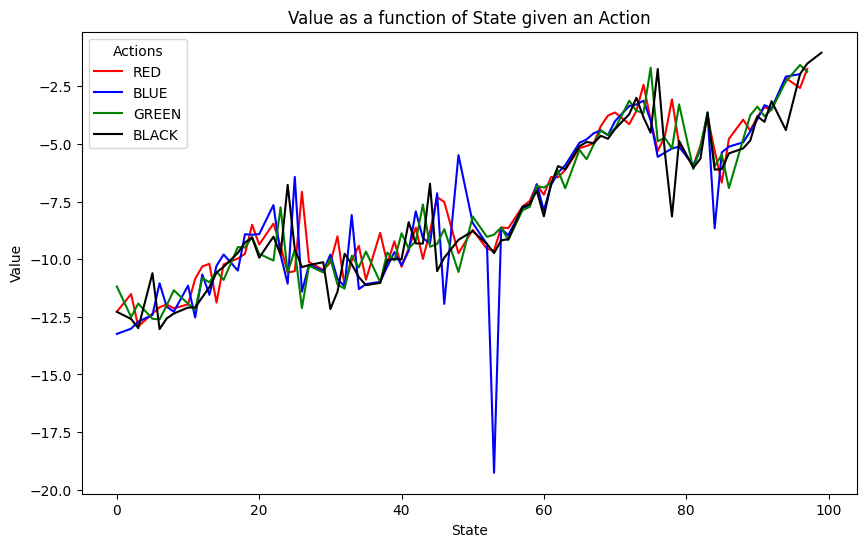

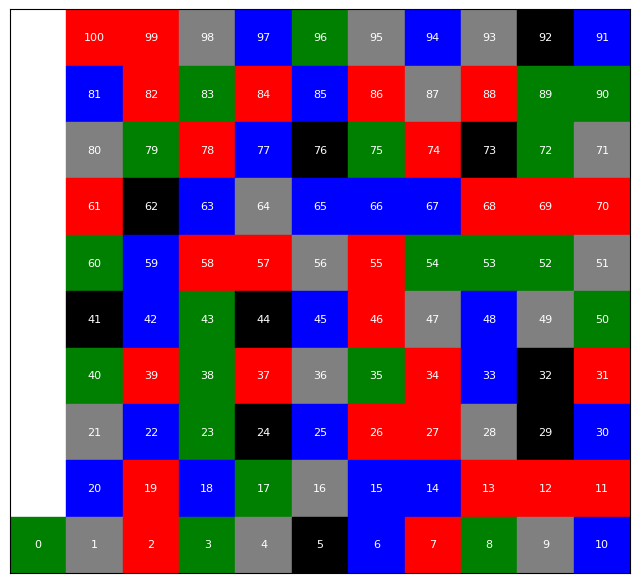

In [55]:
alpha = 0.05
epsilon = 0.1
gamma = 0.99

policy_mc, value_mc = monteCarlo(10000)

print(policy_mc)
print(value_mc)

plot_value(value_mc)

plot_policy(policy_mc)

---
## Dynamic Programming

### Setting up the Game

In [47]:
ladders = {1: 38, 4: 14, 9: 31, 21: 42, 36: 44, 51: 67, 71: 91, 28: 84, 80: 100} #To climb closer to the goal
chutes = {16: 6, 49: 11, 47: 26, 87: 24, 56: 53, 64: 60, 93: 73, 95: 75, 98: 78} #Sets you farther away from the goal

# number of states
n = 100
goal_sate = 100

#dices
dices = {'red': {2: 2/3, 6: 1/3},
         'blue': {3: 1.0},
         'green': {1: 1/2, 5: 1/2},
         'black': {0: 1/3, 4: 2/3}}

actions = list(dices.keys()) #name of the dices

In [48]:
def state_after_event(position):
    '''
    Entering a state after being sent either up or down from a chute/ladder
    '''
    while position in ladders or position in chutes:
        if position in ladders:
            position = ladders[position]
        elif position in chutes:
            position = chutes[position]
    return position

# Adding the normal states that have nothing special to them
normal_states = []
for state in range(0, n+1):
    if state == goal_sate:
        normal_states.append(state)
        continue

    if state in chutes or state in ladders:
        continue

    normal_states.append(state)

# Creating final mapping of the entire board game
stable_state_to_index = {s: i for i, s in enumerate(normal_states)}

pprint.pprint(stable_state_to_index)

{0: 0,
 2: 1,
 3: 2,
 5: 3,
 6: 4,
 7: 5,
 8: 6,
 10: 7,
 11: 8,
 12: 9,
 13: 10,
 14: 11,
 15: 12,
 17: 13,
 18: 14,
 19: 15,
 20: 16,
 22: 17,
 23: 18,
 24: 19,
 25: 20,
 26: 21,
 27: 22,
 29: 23,
 30: 24,
 31: 25,
 32: 26,
 33: 27,
 34: 28,
 35: 29,
 37: 30,
 38: 31,
 39: 32,
 40: 33,
 41: 34,
 42: 35,
 43: 36,
 44: 37,
 45: 38,
 46: 39,
 48: 40,
 50: 41,
 52: 42,
 53: 43,
 54: 44,
 55: 45,
 57: 46,
 58: 47,
 59: 48,
 60: 49,
 61: 50,
 62: 51,
 63: 52,
 65: 53,
 66: 54,
 67: 55,
 68: 56,
 69: 57,
 70: 58,
 72: 59,
 73: 60,
 74: 61,
 75: 62,
 76: 63,
 77: 64,
 78: 65,
 79: 66,
 81: 67,
 82: 68,
 83: 69,
 84: 70,
 85: 71,
 86: 72,
 88: 73,
 89: 74,
 90: 75,
 91: 76,
 92: 77,
 94: 78,
 96: 79,
 97: 80,
 99: 81,
 100: 82}


In [49]:
# Getting the probability of dice rolls

def probability(state, action):

    # if the state is in the goal then we can't move anywhere
    if state == goal_sate:
        return {goal_sate: 1.0}
    
    prob = {}

    # were chechking the dice values
    for dice_roll, p in dices[action].items():
        next_state = state + dice_roll
        if next_state >= goal_sate:
            s_prime = goal_sate
        else:
            s_prime = state_after_event(next_state)
        prob[s_prime] = prob.get(s_prime, 0) + p  
    return prob


In [50]:
gamma = 0.9999  # or 0.99, some value less than 1

def matrix(policy):
    num_states = len(normal_states)
    A = np.zeros((num_states, num_states))
    b = np.zeros(num_states)

    for i, s in enumerate(normal_states):
        if s == goal_sate:
            A[i, i] = 1.0
            b[i] = 0.0
        else:
            a = policy[s]
            T = probability(s, a)

            A[i, i] = 1.0
            b[i] = -1.0

            for s_prime, p in T.items():
                j = stable_state_to_index[s_prime]
                A[i, j] -= gamma * p

    V = np.linalg.solve(A, b)
    return V

In [51]:
def local_search(policy):
    stable_initial = stable_state_to_index[0]
    changed = False  # Initialize changed to False at the start
    
    V = matrix(policy)
    base_value = V[stable_initial]

    for s in normal_states:
        if s == goal_sate:
            continue
        current_action = policy[s]
        best_action = current_action
        best_value = base_value
        for a in actions:
            if a == current_action:
                continue
            old_action = policy[s]
            policy[s] = a
            new_V = matrix(policy)
            new_value = new_V[stable_initial]
            if new_value > best_value:
                best_value = new_value
                best_action = a
            policy[s] = old_action
        if best_action != current_action:
            policy[s] = best_action
            changed = True  # Set changed to True when a change is made
    
    return changed  # This will now return False if no changes were made, True if at least one change occurred

In [52]:
def plot_policy(policy):
    """Takes in a policy dictionary (map from state:action) and draws in on the board"""
    grid = np.zeros((10, 10), dtype=int)

    #creates and numbers the base 1-100 grid
    number = 1
    for row in range(10):
        #logic to snake the numbers
        if row % 2 == 0:
            for col in range(10):
                grid[9 - row, col] = number
                number += 1
        else:
            for col in range(9, -1, -1):
                grid[9 - row, col] = number
                number += 1

    #create 2d matrix of colors
    colors = []
    for row in range(10):
        row_colors = []
        for col in range(10):
            cell_number = grid[row, col]
            row_colors.append(policy.get(cell_number, 'grey'))  # Default to grey if not in policy
        colors.append(row_colors)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    # account for starting square 0. Placed it to the left of the 1st spot outside of the 10x10 grid
    ax.add_patch(
        plt.Rectangle((-1, 9), 1, 1, color=policy.get(0, 'grey'))
    )
    ax.text(
        -0.5, 9.5, '0',
        color='white', ha='center', va='center', fontsize=8
    )

    # actually draw the grid
    for row in range(10):
        for col in range(10):
            ax.add_patch(
                plt.Rectangle((col, row), 1, 1, color=colors[row][col])
            )
            ax.text(
                col + 0.5, row + 0.5, str(grid[row, col]),
                color='white', ha='center', va='center', fontsize=8
            )

    ax.set_xlim(-1, 10)
    ax.set_ylim(0, 10)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.gca().invert_yaxis()
    plt.show()

### Testing Below

In [53]:
policy = {s: 'blue' for s in normal_states}

while True:
    better_action = local_search(policy)
    if not better_action:
        break

final_V = matrix(policy)
print("Best Policy")
for s in sorted(policy.keys()):
    print(f"State {s}: Action {policy[s]}")
print("Value of initial state:", final_V[stable_state_to_index[0]])

Best Policy
State 0: Action black
State 2: Action red
State 3: Action red
State 5: Action blue
State 6: Action blue
State 7: Action red
State 8: Action red
State 10: Action blue
State 11: Action blue
State 12: Action blue
State 13: Action blue
State 14: Action green
State 15: Action black
State 17: Action red
State 18: Action blue
State 19: Action blue
State 20: Action red
State 22: Action red
State 23: Action blue
State 24: Action black
State 25: Action blue
State 26: Action blue
State 27: Action blue
State 29: Action blue
State 30: Action blue
State 31: Action blue
State 32: Action blue
State 33: Action blue
State 34: Action blue
State 35: Action blue
State 37: Action blue
State 38: Action blue
State 39: Action blue
State 40: Action blue
State 41: Action blue
State 42: Action blue
State 43: Action blue
State 44: Action blue
State 45: Action blue
State 46: Action blue
State 48: Action blue
State 50: Action blue
State 52: Action blue
State 53: Action blue
State 54: Action blue
State 55

Best Policy
State 0: Action black
State 2: Action red
State 3: Action red
State 5: Action blue
State 6: Action blue
State 7: Action red
State 8: Action red
State 10: Action blue
State 11: Action blue
State 12: Action blue
State 13: Action blue
State 14: Action green
State 15: Action black
State 17: Action red
State 18: Action blue
State 19: Action blue
State 20: Action red
State 22: Action red
State 23: Action blue
State 24: Action black
State 25: Action blue
State 26: Action blue
State 27: Action blue
State 29: Action blue
State 30: Action blue
State 31: Action blue
State 32: Action blue
State 33: Action blue
State 34: Action blue
State 35: Action blue
State 37: Action blue
State 38: Action blue
State 39: Action blue
State 40: Action blue
State 41: Action blue
State 42: Action blue
State 43: Action blue
State 44: Action blue
State 45: Action blue
State 46: Action blue
State 48: Action blue
State 50: Action blue
State 52: Action blue
State 53: Action blue
State 54: Action blue
State 55

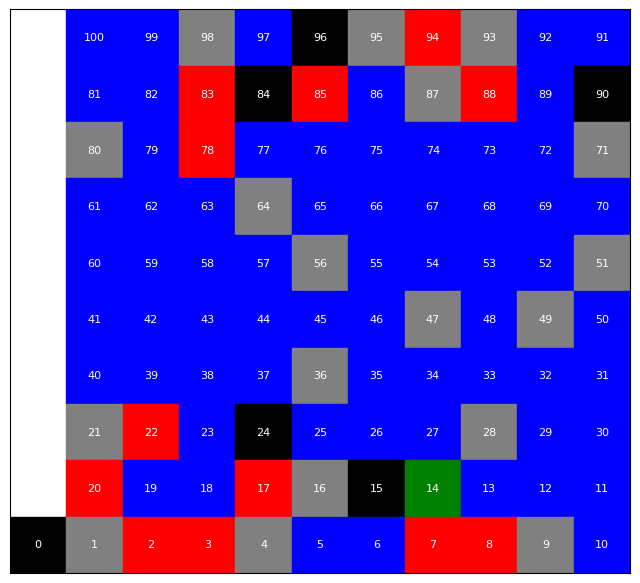

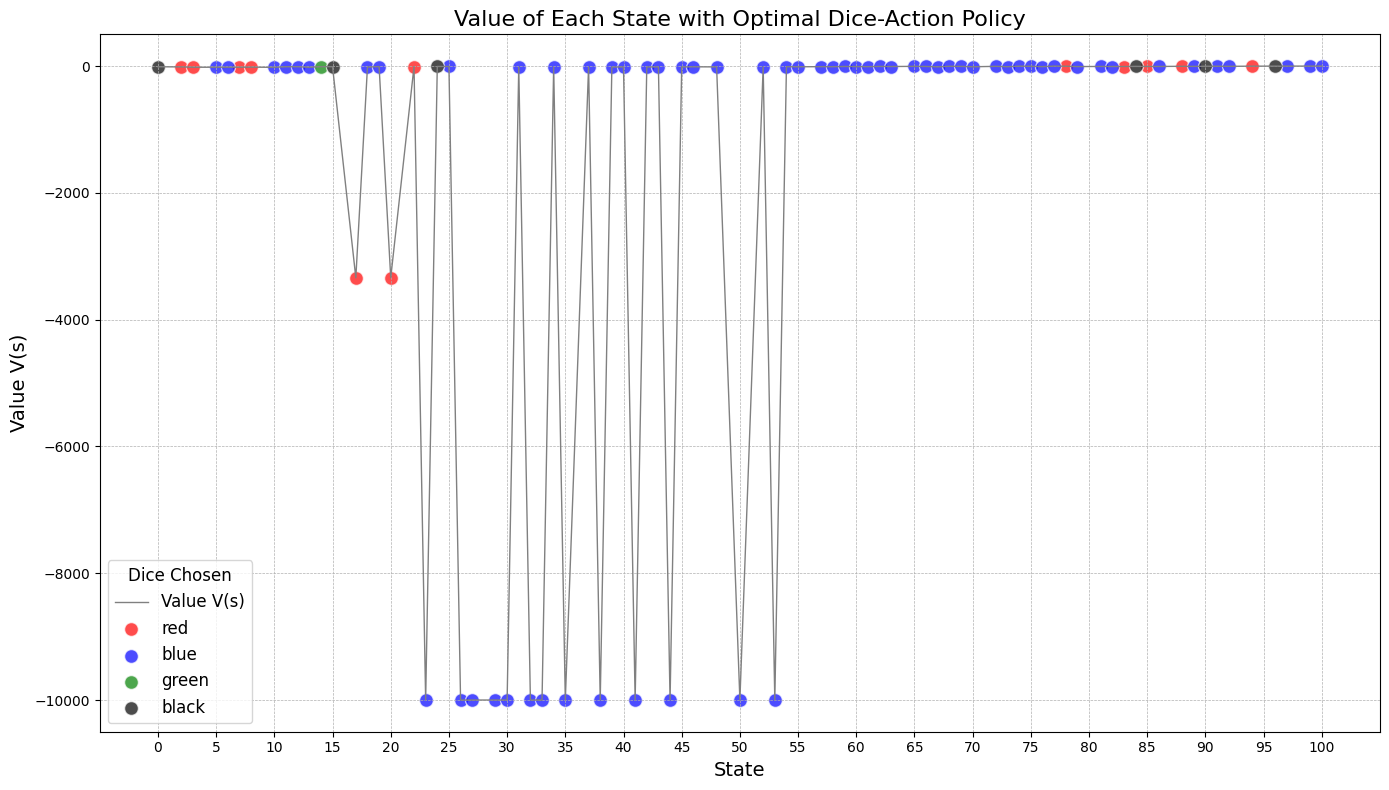

In [54]:
# Initialize and improve policy
policy = {s: 'blue' for s in normal_states}

while True:
    better_action = local_search(policy)
    if not better_action:
        break

final_V = matrix(policy)

print("Best Policy")
for s in sorted(policy.keys()):
    print(f"State {s}: Action {policy[s]}")
print("Value of initial state:", final_V[stable_state_to_index[0]])

# Plot the final policy on the board
plot_policy(policy)

color_map = {'red': 'r', 'blue': 'b', 'green': 'g', 'black': 'k'}
sorted_states = sorted(normal_states)
values = [final_V[stable_state_to_index[s]] for s in sorted_states]

states_by_action = {a: [] for a in actions}
values_by_action = {a: [] for a in actions}

for s in sorted_states:
    a = policy[s]
    states_by_action[a].append(s)
    values_by_action[a].append(final_V[stable_state_to_index[s]])

plt.figure(figsize=(14, 8))
plt.plot(sorted_states, values, color='gray', linewidth=1, label='Value V(s)')

for a in actions:
    plt.scatter(states_by_action[a], values_by_action[a], c=color_map[a], 
                label=a, alpha=0.7, edgecolors='w', s=100)

plt.title("Value of Each State with Optimal Dice-Action Policy", fontsize=16)
plt.xlabel("State", fontsize=14)
plt.ylabel("Value V(s)", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title="Dice Chosen", fontsize=12, title_fontsize=12)
plt.xticks(range(0, 101, 5))
plt.tight_layout()
plt.show()